# Example for cistrome imputation using prompt-enhanced ChromBERT

ChromBERT's context-specific TRN embeddings can be used to impute cell-type-specific cistromes through prompt engineering. In this tutorial, we demonstrate how to impute cistromes for a given cell type using ChromBERT. The model has been trained with two types of prompts: DNase-seq prompts from ChromBERT and RNA-seq prompts from scGPT. Pre-trained model checkpoints are available on [Huggingface](https://huggingface.co/datasets/TongjiZhanglab/chrombert).

To follow this tutorial, you will need to download the checkpoint files (see the [Installation Guide](https://chrombert.readthedocs.io/en/latest/installation.html) for details).

**Attention: You should go through this  [tutorial](https://chrombert.readthedocs.io/en/latest/tutorial_finetuning_ChromBERT.html)  at first to get familiar with the basic usage of ChromBERT.**

In [1]:
import  os 
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # to selected gpu used 

import sys 
import pathlib 
import pickle

import torch 
import numpy as np 
import pandas as pd 
from tqdm import tqdm 
from matplotlib import pyplot as plt
import seaborn as sns
import chrombert
from torchinfo import summary

import lightning.pytorch as pl

import sklearn 
import sklearn.metrics

basedir = os.path.expanduser("~/.cache/chrombert/data"  )



/home/yangdongxu/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Cistrome-prompt enhanced ChromBERT


We provide a preset model configuration for DNase-seq data that loads a fine-tuned checkpoint and sets dropout to 0 to ensure deterministic predictions.  
To fine-tune the model on your own data, use `chrombert.get_preset_model_config(...,dropout=0.1)` to enable dropout during training, and set `finetune_ckpt=None` to start from the pretrained checkpoint.

### prepare model

Create the ChromBERT model with cistrome prompt configuration, same as in other tutorials.  
The model is initialized with pretrained weights and set to evaluation mode.


In [2]:
mc = chrombert.get_preset_model_config("prompt_cistrome", dropout = 0) 
model = mc.init_model().cuda().bfloat16().eval()
mc

update path: mtx_mask = config/hg38_6k_mask_matrix.tsv
update path: pretrain_ckpt = checkpoint/hg38_6k_1kb_pretrain.ckpt
update path: finetune_ckpt = checkpoint/hg38_6k_1kb_prompt_cistrome.ckpt
use organisim hg38; max sequence length including cls is 6392
Loading checkpoint from /home/yangdongxu/.cache/chrombert/data/checkpoint/hg38_6k_1kb_prompt_cistrome.ckpt
Loaded 30/30 parameters


ChromBERTFTConfig(genome='hg38', task='prompt', dim_output=1, mtx_mask='/home/yangdongxu/.cache/chrombert/data/config/hg38_6k_mask_matrix.tsv', dropout=0, pretrain_ckpt='/home/yangdongxu/.cache/chrombert/data/checkpoint/hg38_6k_1kb_pretrain.ckpt', finetune_ckpt='/home/yangdongxu/.cache/chrombert/data/checkpoint/hg38_6k_1kb_prompt_cistrome.ckpt', ignore=False, ignore_index=(None, None), gep_flank_window=4, gep_parallel_embedding=False, gep_gradient_checkpoint=False, gep_zero_inflation=True, prompt_kind='cistrome', prompt_dim_external=768, dnabert2_ckpt=None)

### prepare dataset

In [3]:
summary(model)

Layer (type:depth-idx)                                  Param #
ChromBERTPrompt                                         --
├─ChromBERT: 1-1                                        --
│    └─BERTEmbedding: 2-1                               --
│    │    └─TokenEmbedding: 3-1                         7,680
│    │    └─PositionalEmbedding: 3-2                    4,909,056
│    │    └─Dropout: 3-3                                --
│    └─ModuleList: 2-2                                  --
│    │    └─EncoderTransformerBlock: 3-4                6,497,280
│    │    └─EncoderTransformerBlock: 3-5                6,497,280
│    │    └─EncoderTransformerBlock: 3-6                6,497,280
│    │    └─EncoderTransformerBlock: 3-7                6,497,280
│    │    └─EncoderTransformerBlock: 3-8                6,497,280
│    │    └─EncoderTransformerBlock: 3-9                6,497,280
│    │    └─EncoderTransformerBlock: 3-10               6,497,280
│    │    └─EncoderTransformerBlock: 3-11          

In [ ]:
table_peak = os.path.join(basedir, "demo","prompt_imputation", "MAZ_K562_narrowPeak.bed")
! head {table_peak}

chr9	6015447	6015882	peak62341	3027	.	29.11372	312.26147	302.77042	210
chr19	10027662	10028051	peak30656	3015	.	29.01156	310.75055	301.56052	200
chr5	168486223	168486709	peak51278	2920	.	27.98132	299.79123	292.07101	184
chr3	93470271	93470886	peak44388	2688	.	23.79757	276.11172	268.88312	233
chr17	59565331	59565789	peak27510	2593	.	24.16347	266.44458	259.33734	224
chr1	50720506	50720844	peak2756	2492	.	25.26958	256.13898	249.21376	166
chr7	155069957	155070335	peak59492	2442	.	27.61181	251.12788	244.27632	173
chr1	148522501	148523033	peak4345	2362	.	28.98589	243.01486	236.26180	182
chr11	47552717	47553441	peak11765	2350	.	20.41753	241.80923	235.08012	476
chr6	33788819	33789378	peak53313	2323	.	19.06412	239.08537	232.39090	379


In [5]:
# Align genomic coordinates from the narrowPeak file to the Human-Cistrome-6k dataset regions

from chrombert.scripts.chrombert_make_dataset import get_overlap

df_supervised = get_overlap(
    supervised = table_peak, # a narrowPeak file
    regions = os.path.join(basedir, "config", "hg38_6k_1kb_region.bed"),
    no_filter = True,
).assign(label = lambda df: df["label"] > 0 )
df_supervised

,chrom,start,end,build_region_index,label
0,chr1,10000,11000,0,False
1,chr1,16000,17000,1,False
2,chr1,17000,18000,2,False
3,chr1,29000,30000,3,False
4,chr1,30000,31000,4,False
...,...,...,...,...,...
2137889,chrY,26671000,26672000,2137889,False
2137890,chrY,56674000,56675000,2137890,False
2137891,chrY,56678000,56679000,2137891,False
2137892,chrY,56684000,56685000,2137892,False


In [6]:
tmpdir = pathlib.Path("tmp_prompt")
tmpdir.mkdir(exist_ok = True)
df_supervised_sampled = df_supervised.query("chrom == 'chr1' ").groupby("label").sample(1000, random_state = 0)
supervised_file = tmpdir / "supervised.csv"
df_supervised_sampled.to_csv(supervised_file,index = False)
df_supervised_sampled # we have `label` column now, but for prediction, we don't need it

,chrom,start,end,build_region_index,label
172348,chr1,234585000,234586000,172348,False
61761,chr1,72634000,72635000,61761,False
102644,chr1,150939000,150940000,102644,False
67475,chr1,80752000,80753000,67475,False
141933,chr1,199549000,199550000,141933,False
...,...,...,...,...,...
44233,chr1,51661000,51662000,44233,True
127936,chr1,181166000,181167000,127936,True
36987,chr1,42825000,42826000,36987,True
115176,chr1,165829000,165830000,115176,True


Here we will use the preset dataset configuration to prepare the dataset.   
<!--- We set `prompt_regulator_cache_file` and `prompt_celltype_cache_file` as `None` to disable using cache file. For more about cache file, see below section --->

In [7]:
# Create the dataset configuration with preset parameters for DNase-seq data.
dc = chrombert.get_preset_dataset_config(
    "prompt_cistrome", 
    supervised_file = str(supervised_file), 
    batch_size = 1,
    prompt_regulator = "maz", # factors to predict
    prompt_celltype = "dnase:k562", # cell type specific cistrome. you can use other cistromes such "h3k27ac:gm12878" for specific target and maybe better, but dnase is recommended for general purpose
    )
print(dc)

update path: hdf5_file = hg38_6k_1kb.hdf5
update path: meta_file = config/hg38_6k_meta.json
{
    "hdf5_file": "/home/yangdongxu/.cache/chrombert/data/hg38_6k_1kb.hdf5",
    "supervised_file": "tmp_prompt/supervised.csv",
    "kind": "PromptDataset",
    "meta_file": "/home/yangdongxu/.cache/chrombert/data/config/hg38_6k_meta.json",
    "ignore": false,
    "ignore_object": null,
    "batch_size": 1,
    "num_workers": 20,
    "shuffle": false,
    "perturbation": false,
    "perturbation_object": null,
    "perturbation_value": 0,
    "prompt_kind": "cistrome",
    "prompt_regulator": "maz",
    "prompt_regulator_cache_file": null,
    "prompt_celltype": "dnase:k562",
    "prompt_celltype_cache_file": null,
    "fasta_file": null,
    "flank_window": 0
}


In [8]:
# initialize dataset
ds = dc.init_dataset()
ds[1]

{'input_ids': tensor([6, 6, 6,  ..., 6, 5, 6], dtype=torch.int8),
 'position_ids': tensor([   1,    2,    3,  ..., 6389, 6390, 6391]),
 'region': tensor([       1, 72634000, 72635000], dtype=torch.int32),
 'build_region_index': 61761,
 'label': False,
 'prompts_cell': tensor([0, 0, 0,  ..., 0, 0, 0]),
 'prompts_all': tensor([1, 1, 1,  ..., 1, 1, 1]),
 'prompts_regulator': tensor([0, 0, 0,  ..., 0, 0, 0]),
 'cell': 'dnase:k562',
 'regulator': 'maz'}

### forward

In [9]:
dl = dc.init_dataloader()
list_regions = []
list_logits = []
list_indices = []
list_labels = []
with torch.no_grad():
    for batch in tqdm(dl):
        for k,v in batch.items():
            if isinstance(v, torch.Tensor):
                batch[k] = v.cuda()

        logit = model(batch).float().cpu()
        list_regions.append(batch["region"].cpu())
        list_logits.append(logit)
        list_indices.append(batch["build_region_index"].cpu())
        list_labels.append(batch["label"].cpu())


100%|██████████| 2000/2000 [00:49<00:00, 40.30it/s]


In [10]:
logit = torch.cat(list_logits).float().numpy()
regions = torch.cat(list_regions).numpy()
indices = torch.cat(list_indices).numpy()
labels = torch.cat(list_labels).numpy()
df_predict_1 = pd.DataFrame(regions, columns = ["chrom", "start", "end"])
df_predict_1["build_region_index"] = indices
df_predict_1["label"] = labels
df_predict_1["logit"] = logit
df_predict_1["prob"] = torch.sigmoid(torch.tensor(logit)).numpy()
df_predict_1

,chrom,start,end,build_region_index,label,logit,prob
0,1,234585000,234586000,172348,False,-2.718750,0.061876
1,1,72634000,72635000,61761,False,-6.093750,0.002252
2,1,150939000,150940000,102644,False,-5.062500,0.006290
3,1,80752000,80753000,67475,False,-5.843750,0.002890
4,1,199549000,199550000,141933,False,-4.843750,0.007816
...,...,...,...,...,...,...,...
1995,1,51661000,51662000,44233,True,-1.039062,0.261331
1996,1,181166000,181167000,127936,True,0.648438,0.656658
1997,1,42825000,42826000,36987,True,0.542969,0.632503
1998,1,165829000,165830000,115176,True,-1.351562,0.205615


Below we validate the model's performance by examining prediction probabilities and ROC curves.

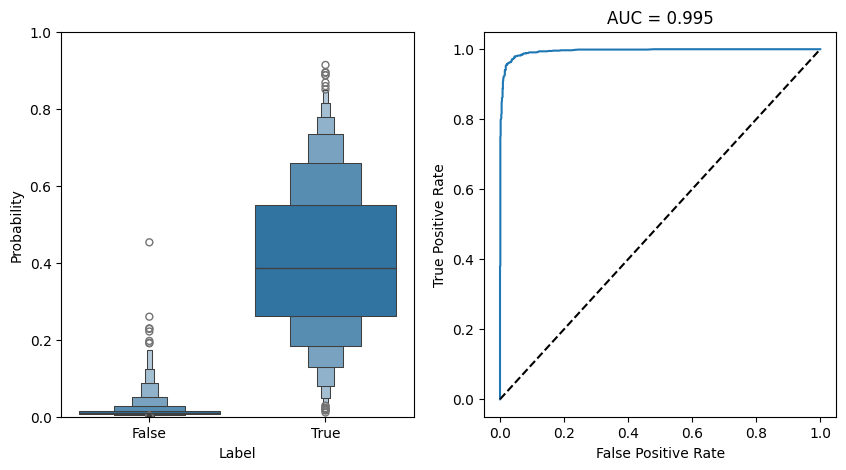

In [11]:
fig, axs = plt.subplots(1,2, figsize = (10,5))
ax = axs[0]
sns.boxenplot(data = df_predict_1, x = "label", y = "prob", ax = ax)
ax.set_ylabel("Probability")
ax.set_xlabel("Label")
ax.set_ylim(0,1)

ax = axs[1]
fpr, tpr, _ = sklearn.metrics.roc_curve(df_predict_1["label"], df_predict_1["prob"])
auc = sklearn.metrics.auc(fpr, tpr)
ax.plot(fpr, tpr, label = f"AUC = {auc:.3f}")

ax.plot([0,1],[0,1], linestyle = "--", color = "black")
ax.set_title(f"AUC = {auc:.3f}")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")

fig.show()

### Cached File

Since prompt imputation is resource-intensive, we provide a cache file to simplify this process.   

To use it, set `prompt_regulator_cache_file` and `prompt_celltype_cache_file` to the path of the cache file.  

A sample cache file containing data for seven regulators on chromosome 1 is available at `~/.cache/chrombert/data`.   

For large-scale prompt imputation, you can use the provided scripts to generate a cache file tailored to your own data. 

In [12]:
# Initialize model config - prompt_dnase and prompt_cistrome are equivalent configurations
mc = chrombert.get_preset_model_config("prompt_dnase", dropout = 0)
model = mc.init_model().cuda().bfloat16().eval()

# Initialize dataset config with cached prompts
dc = chrombert.get_preset_dataset_config(
    "prompt_dnase",  # Uses cached prompt files for faster loading
    supervised_file = str(supervised_file),
    batch_size = 128, # Larger batch size possible since data loading is the bottleneck
    prompt_regulator = "maz", # Target transcription factor to predict
    prompt_celltype = "dnase:k562", # Cell-type-specific prompt from DNase-seq data used in the pretraining of ChromBERT
    )
ds = dc.init_dataset()
ds[1].keys()

update path: mtx_mask = config/hg38_6k_mask_matrix.tsv
update path: pretrain_ckpt = checkpoint/hg38_6k_1kb_pretrain.ckpt
update path: finetune_ckpt = checkpoint/hg38_6k_1kb_prompt_cistrome.ckpt
use organisim hg38; max sequence length including cls is 6392
Loading checkpoint from /home/yangdongxu/.cache/chrombert/data/checkpoint/hg38_6k_1kb_prompt_cistrome.ckpt
Loaded 30/30 parameters
update path: hdf5_file = hg38_6k_1kb.hdf5
update path: meta_file = config/hg38_6k_meta.json
update path: prompt_regulator_cache_file = cache/hg38_6k_1kb_regulator_prompt_chr1_cache.h5
update path: prompt_celltype_cache_file = cache/hg38_6k_1kb_cistrome_cell_prompt_chr1_cache.h5


dict_keys(['input_ids', 'position_ids', 'region', 'build_region_index', 'label', 'emb_cell', 'emb_regulator', 'emb_all', 'cell', 'regulator'])

#### cache file structure

We use two cache files to store prompts for regulators and cell types.    
The regulator cache file has the following structure:  
- `regions`: Stores region information  
- `all`: Stores region embeddings  
- `emb`: A group containing embeddings for each regulator  

The cell type cache file has the following structure:  
- `regions`: Stores region information  
- `emb`: A group containing embeddings for cell type-specific prompts  


In [13]:
!h5ls {dc.prompt_regulator_cache_file}

all                      Dataset {183983, 768}
emb                      Group
regions                  Dataset {183983, 4}


In [14]:
!h5ls {dc.prompt_regulator_cache_file}/emb

mafk                     Dataset {183983, 768}
maz                      Dataset {183983, 768}
nfya                     Dataset {183983, 768}
nfyb                     Dataset {183983, 768}
nipbl                    Dataset {183983, 768}
srebf1                   Dataset {183983, 768}
zkscan1                  Dataset {183983, 768}


In [15]:
!h5ls {dc.prompt_celltype_cache_file}

emb                      Group
regions                  Dataset {183983, 4}


In [16]:
!h5ls {dc.prompt_celltype_cache_file}/emb

dnase:a549               Dataset {183983, 768}
dnase:gm12878            Dataset {183983, 768}
dnase:hct116             Dataset {183983, 768}
dnase:helas3             Dataset {183983, 768}
dnase:hepg2              Dataset {183983, 768}
dnase:k562               Dataset {183983, 768}
dnase:mcf7               Dataset {183983, 768}


#### forward

In [17]:
dl = dc.init_dataloader()
list_regions = []
list_logits = []
list_indices = []
list_labels = []
with torch.no_grad():
    for batch in tqdm(dl):
        for k,v in batch.items():
            if isinstance(v, torch.Tensor):
                batch[k] = v.cuda()

        logit = model(batch).float().cpu()
        list_regions.append(batch["region"].cpu())
        list_logits.append(logit)
        list_indices.append(batch["build_region_index"].cpu())
        list_labels.append(batch["label"].cpu())


100%|██████████| 16/16 [00:01<00:00,  8.14it/s]


In [18]:
logit = torch.cat(list_logits).float().numpy()
regions = torch.cat(list_regions).numpy()
indices = torch.cat(list_indices).numpy()
labels = torch.cat(list_labels).numpy()
df_predict_2 = pd.DataFrame(regions, columns = ["chrom", "start", "end"])
df_predict_2["build_region_index"] = indices
df_predict_2["label"] = labels
df_predict_2["logit"] = logit
df_predict_2["prob"] = torch.sigmoid(torch.tensor(logit)).numpy()
df_predict_2

,chrom,start,end,build_region_index,label,logit,prob
0,1,234585000,234586000,172348,False,-2.718750,0.061876
1,1,72634000,72635000,61761,False,-6.062500,0.002323
2,1,150939000,150940000,102644,False,-5.062500,0.006290
3,1,80752000,80753000,67475,False,-5.843750,0.002890
4,1,199549000,199550000,141933,False,-4.843750,0.007816
...,...,...,...,...,...,...,...
1995,1,51661000,51662000,44233,True,-1.039062,0.261331
1996,1,181166000,181167000,127936,True,0.648438,0.656658
1997,1,42825000,42826000,36987,True,0.535156,0.630685
1998,1,165829000,165830000,115176,True,-1.343750,0.206894


As demonstrated, using a cached file significantly accelerates the prompt imputation process while maintaining comparable performance, with minimal to no differences resulting from precision conversion.

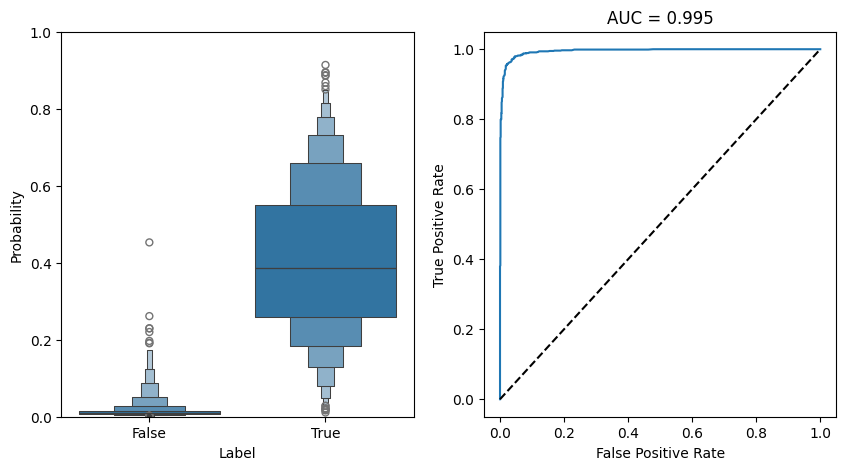

In [19]:
fig, axs = plt.subplots(1,2, figsize = (10,5))
ax = axs[0]
sns.boxenplot(data = df_predict_2, x = "label", y = "prob", ax = ax)
ax.set_ylabel("Probability")
ax.set_xlabel("Label")
ax.set_ylim(0,1)

ax = axs[1]
fpr, tpr, _ = sklearn.metrics.roc_curve(df_predict_2["label"], df_predict_2["prob"])
auc = sklearn.metrics.auc(fpr, tpr)
ax.plot(fpr, tpr, label = f"AUC = {auc:.3f}")

ax.plot([0,1],[0,1], linestyle = "--", color = "black")
ax.set_title(f"AUC = {auc:.3f}")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")

fig.show()

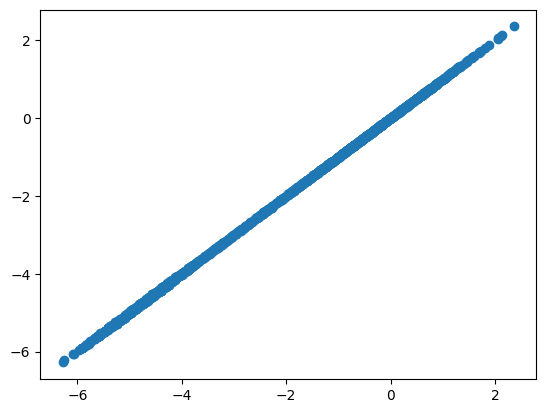

In [20]:
assert all(df_predict_1["build_region_index"] == df_predict_2["build_region_index"])

plt.scatter(df_predict_1["logit"], df_predict_2["logit"])

## RNA-seq prompt enhanced ChromBERT

To enhance ChromBERT, we use the RNA-seq prompt from scGPT.  

### prepare model

The model loading process is similar to before, but uses the `prompt_exp` preset instead. This preset loads a checkpoint that was fine-tuned using scGPT embeddings derived from bulk RNA-seq data.

In [21]:
mc = chrombert.get_preset_model_config("prompt_exp", dropout = 0) 
model = mc.init_model().cuda().bfloat16().eval()
mc

update path: mtx_mask = config/hg38_6k_mask_matrix.tsv
update path: pretrain_ckpt = checkpoint/hg38_6k_1kb_pretrain.ckpt
update path: finetune_ckpt = checkpoint/hg38_6k_1kb_prompt_expression.ckpt
use organisim hg38; max sequence length including cls is 6392
Loading checkpoint from /home/yangdongxu/.cache/chrombert/data/checkpoint/hg38_6k_1kb_prompt_expression.ckpt
Loaded 44/44 parameters


ChromBERTFTConfig(genome='hg38', task='prompt', dim_output=1, mtx_mask='/home/yangdongxu/.cache/chrombert/data/config/hg38_6k_mask_matrix.tsv', dropout=0, pretrain_ckpt='/home/yangdongxu/.cache/chrombert/data/checkpoint/hg38_6k_1kb_pretrain.ckpt', finetune_ckpt='/home/yangdongxu/.cache/chrombert/data/checkpoint/hg38_6k_1kb_prompt_expression.ckpt', ignore=False, ignore_index=(None, None), gep_flank_window=4, gep_parallel_embedding=False, gep_gradient_checkpoint=False, gep_zero_inflation=True, prompt_kind='expression', prompt_dim_external=512, dnabert2_ckpt=None)

In [22]:
summary(model)

Layer (type:depth-idx)                                  Param #
ChromBERTPrompt                                         --
├─ChromBERT: 1-1                                        --
│    └─BERTEmbedding: 2-1                               --
│    │    └─TokenEmbedding: 3-1                         7,680
│    │    └─PositionalEmbedding: 3-2                    4,909,056
│    │    └─Dropout: 3-3                                --
│    └─ModuleList: 2-2                                  --
│    │    └─EncoderTransformerBlock: 3-4                6,497,280
│    │    └─EncoderTransformerBlock: 3-5                6,497,280
│    │    └─EncoderTransformerBlock: 3-6                6,497,280
│    │    └─EncoderTransformerBlock: 3-7                6,497,280
│    │    └─EncoderTransformerBlock: 3-8                6,497,280
│    │    └─EncoderTransformerBlock: 3-9                6,497,280
│    │    └─EncoderTransformerBlock: 3-10               6,497,280
│    │    └─EncoderTransformerBlock: 3-11          

### prepare dataset

The cell embeddings generated by scGPT are stored in a `.pkl` file, and the regulator embedding cache will be used for our analysis.


In [23]:
dc = chrombert.get_preset_dataset_config(
    "prompt_exp", 
    supervised_file = str(supervised_file), 
    batch_size = 1,
    prompt_regulator = "maz", # target of prediction
    prompt_celltype = "k562", # cell type of RNA-seq prompt. Must be key in the provided cache file. 
    )
print(dc)

update path: hdf5_file = hg38_6k_1kb.hdf5
update path: meta_file = config/hg38_6k_meta.json
update path: prompt_regulator_cache_file = cache/hg38_6k_1kb_regulator_prompt_chr1_cache.h5
update path: prompt_celltype_cache_file = cache/hg38_6k_1kb_expression_cell_prompt_cache.pkl
{
    "hdf5_file": "/home/yangdongxu/.cache/chrombert/data/hg38_6k_1kb.hdf5",
    "supervised_file": "tmp_prompt/supervised.csv",
    "kind": "PromptDataset",
    "meta_file": "/home/yangdongxu/.cache/chrombert/data/config/hg38_6k_meta.json",
    "ignore": false,
    "ignore_object": null,
    "batch_size": 1,
    "num_workers": 20,
    "shuffle": false,
    "perturbation": false,
    "perturbation_object": null,
    "perturbation_value": 0,
    "prompt_kind": "expression",
    "prompt_regulator": "maz",
    "prompt_regulator_cache_file": "/home/yangdongxu/.cache/chrombert/data/cache/hg38_6k_1kb_regulator_prompt_chr1_cache.h5",
    "prompt_celltype": "k562",
    "prompt_celltype_cache_file": "/home/yangdongxu/.cac

In [24]:
with open(dc.prompt_celltype_cache_file,"rb") as f:
    tmp = pickle.load(f)
    print(tmp.keys())
    print(tmp["k562"].shape)

dict_keys(['a172', 'a375', 'a549', 'a673', 'ag04450', 'be2c', 'bj', 'caco2', 'caki2', 'calu3', 'daoy', 'g401', 'gm12878', 'gm12891', 'gm12892', 'h1', 'h4', 'h7', 'h9', 'hct116', 'helas3', 'hepg2', 'ht1080', 'ht29', 'hues64', 'imr90', 'k562', 'karpas422', 'lhcnm2', 'm059j', 'mcf10a', 'mcf7', 'mg63', 'ncih460', 'ocily7', 'panc1', 'pc3', 'pc9', 'pfsk1', 'rpmi7951', 'sjcrh30', 'sjsa1', 'skmel5', 'sknsh', 'u87mg'])
(512,)


In [25]:
dl = dc.init_dataloader()
list_regions = []
list_logits = []
list_indices = []
list_labels = []
with torch.no_grad():
    for batch in tqdm(dl):
        for k,v in batch.items():
            if isinstance(v, torch.Tensor):
                batch[k] = v.cuda()

        logit = model(batch).float().cpu()
        list_regions.append(batch["region"].cpu())
        list_logits.append(logit)
        list_indices.append(batch["build_region_index"].cpu())
        list_labels.append(batch["label"].cpu())


100%|██████████| 2000/2000 [00:16<00:00, 122.19it/s]


In [26]:
logit = torch.cat(list_logits).float().numpy()
regions = torch.cat(list_regions).numpy()
indices = torch.cat(list_indices).numpy()
labels = torch.cat(list_labels).numpy()
df_predict_3 = pd.DataFrame(regions, columns = ["chrom", "start", "end"])
df_predict_3["build_region_index"] = indices
df_predict_3["label"] = labels
df_predict_3["logit"] = logit
df_predict_3["prob"] = torch.sigmoid(torch.tensor(logit)).numpy()
df_predict_3

,chrom,start,end,build_region_index,label,logit,prob
0,1,234585000,234586000,172348,False,-3.812500,2.161533e-02
1,1,72634000,72635000,61761,False,-13.937500,8.851570e-07
2,1,150939000,150940000,102644,False,-11.312500,1.221908e-05
3,1,80752000,80753000,67475,False,-13.375000,1.553498e-06
4,1,199549000,199550000,141933,False,-11.812500,7.411280e-06
...,...,...,...,...,...,...,...
1995,1,51661000,51662000,44233,True,-3.453125,3.067580e-02
1996,1,181166000,181167000,127936,True,1.062500,7.431679e-01
1997,1,42825000,42826000,36987,True,0.578125,6.406359e-01
1998,1,165829000,165830000,115176,True,-1.500000,1.824255e-01


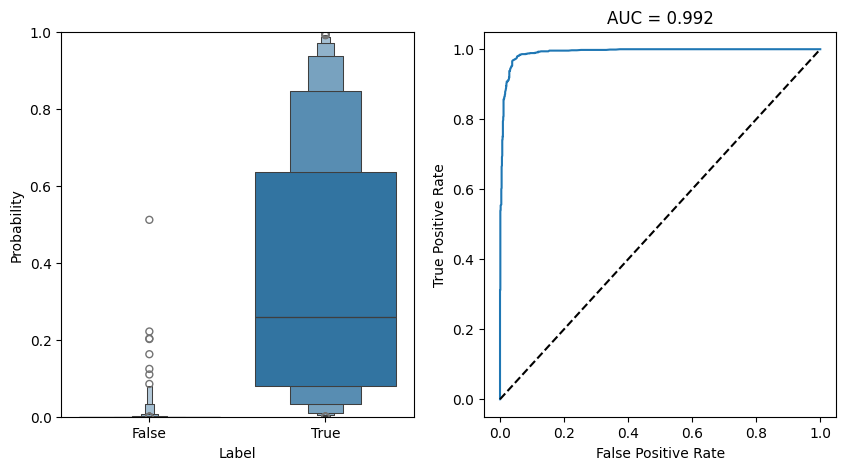

In [27]:
fig, axs = plt.subplots(1,2, figsize = (10,5))
ax = axs[0]
sns.boxenplot(data = df_predict_3, x = "label", y = "prob", ax = ax)
ax.set_ylabel("Probability")
ax.set_xlabel("Label")
ax.set_ylim(0,1)

ax = axs[1]
fpr, tpr, _ = sklearn.metrics.roc_curve(df_predict_3["label"], df_predict_3["prob"])
auc = sklearn.metrics.auc(fpr, tpr)
ax.plot(fpr, tpr, label = f"AUC = {auc:.3f}")

ax.plot([0,1],[0,1], linestyle = "--", color = "black")
ax.set_title(f"AUC = {auc:.3f}")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")

fig.show()

## Single-cell prompt enhanced ChromBERT

Generating single-cell cistromes using the scGPT cell prompt follows the same procedure as for bulk-level data.   

For convenience, we support datasets in H5 format, which include `cell` and `regions` tables for prediction. The `cell` table contains cell names corresponding to keys in the cell prompt cache file.   

The `regions` table includes four columns: `chrom`, `start`, `end`, and `build_region_index`, which can be inferred from the previously imputed datasets.  

In [ ]:
supervised_file = os.path.join(basedir, "demo","prompt_imputation", "pbmc10k.h5")
!h5ls {supervised_file} 

cell                     Dataset {9629}
regions                  Dataset {13480, 4}


In [29]:
dc = chrombert.get_preset_dataset_config(
    "prompt_exp_pbmc", # it uses `prompt_celltype` cache we provided
    supervised_file = supervised_file, 
    batch_size = 1024,
    num_workers = 32,
    prompt_regulator = "maz", # factors to predict
    )
print(dc)

update path: hdf5_file = hg38_6k_1kb.hdf5
update path: meta_file = config/hg38_6k_meta.json
update path: prompt_regulator_cache_file = cache/hg38_6k_1kb_regulator_prompt_chr1_cache.h5
update path: prompt_celltype_cache_file = cache/pbmc10k_scgpt_cell_prompt_cache.pkl
{
    "hdf5_file": "/home/yangdongxu/.cache/chrombert/data/hg38_6k_1kb.hdf5",
    "supervised_file": "/home/yangdongxu/.cache/chrombert/data/demo/prompt_generation/pbmc10k.h5",
    "kind": "PromptDataset",
    "meta_file": "/home/yangdongxu/.cache/chrombert/data/config/hg38_6k_meta.json",
    "ignore": false,
    "ignore_object": null,
    "batch_size": 1024,
    "num_workers": 32,
    "shuffle": false,
    "perturbation": false,
    "perturbation_object": null,
    "perturbation_value": 0,
    "prompt_kind": "expression",
    "prompt_regulator": "maz",
    "prompt_regulator_cache_file": "/home/yangdongxu/.cache/chrombert/data/cache/hg38_6k_1kb_regulator_prompt_chr1_cache.h5",
    "prompt_celltype": null,
    "prompt_cellt

In [30]:
ds = dc.init_dataset()
print(ds[1].keys())

# for each cell, it yields all regions orderly.
print(ds[1]["cell"] == ds[2]["cell"]) 
print(ds[1]["build_region_index"] == ds[2]["build_region_index"])  

dict_keys(['input_ids', 'position_ids', 'region', 'build_region_index', 'emb_cell', 'emb_regulator', 'emb_all', 'cell', 'regulator'])
True
False


In [31]:
n_regions = 13480
target_cells = 256 # we just predict limit cells here
num_steps = n_regions/ dc.batch_size * target_cells

list_regions = []
list_logits = []
list_indices = []
list_cells = []

for i, batch in enumerate(tqdm(dc.init_dataloader(shuffle = False), total = num_steps)):
    if i > num_steps:
        break

    for k,v in batch.items():
        if isinstance(v, torch.Tensor):
            batch[k] = v.cuda()
    with torch.no_grad():
        logit = model(batch).float().cpu()
    list_regions.append(batch["region"].cpu())
    list_indices.append(batch["build_region_index"].cpu())
    list_logits.append(logit)
    list_cells.append(batch["cell"])


3371it [02:43, 20.64it/s]                            


In [32]:
logit = torch.cat(list_logits).float().numpy()
regions = torch.cat(list_regions).numpy()
indices = torch.cat(list_indices).numpy()
cells = np.array(list_cells).flatten()

df_predict_sc = pd.DataFrame(regions, columns = ["chrom", "start", "end"])
df_predict_sc["build_region_index"] = indices
df_predict_sc["logit"] = logit
df_predict_sc["prob"] = torch.sigmoid(torch.tensor(logit)).numpy()
df_predict_sc["cell"] = cells
df_predict_sc

,chrom,start,end,build_region_index,logit,prob,cell
0,1,180000,181000,38,-3.640625,0.025565,AAACAGCCAATCCCTT-1
1,1,191000,192000,46,-5.500000,0.004070,AAACAGCCAATCCCTT-1
2,1,267000,268000,53,-4.125000,0.015906,AAACAGCCAATCCCTT-1
3,1,273000,274000,57,-8.812500,0.000149,AAACAGCCAATCCCTT-1
4,1,280000,281000,60,-8.437500,0.000217,AAACAGCCAATCCCTT-1
...,...,...,...,...,...,...,...
3451899,1,13493000,13494000,10859,-7.062500,0.000856,AAGCAAGTCATGCTTT-1
3451900,1,13498000,13499000,10864,-9.437500,0.000080,AAGCAAGTCATGCTTT-1
3451901,1,13593000,13594000,10945,-5.312500,0.004905,AAGCAAGTCATGCTTT-1
3451902,1,13623000,13624000,10972,-7.687500,0.000458,AAGCAAGTCATGCTTT-1


In [33]:
df_predict_sc_wide = df_predict_sc.set_index(["chrom","start","end","build_region_index","cell"])["prob"].unstack().dropna(axis = 1)
df_predict_sc_wide

cell                                          AAACAGCCAATCCCTT-1  \
chrom start     end       build_region_index                       
1     180000    181000    38                            0.025565   
      191000    192000    46                            0.004070   
      267000    268000    53                            0.015906   
      273000    274000    57                            0.000149   
      280000    281000    60                            0.000217   
...                                                          ...   
      248867000 248868000 183917                        0.000278   
      248873000 248874000 183923                        0.946597   
      248906000 248907000 183953                        0.989986   
      248924000 248925000 183969                        0.160266   
      248945000 248946000 183981                        0.066569   

cell                                          AAACAGCCAATGCGCT-1  \
chrom start     end       build_region_index                       
1     180000    181000    38                            0.022629   
      191000    192000    46                            0.004070   
      267000    268000    53                            0.008316   
      273000    274000    57                            0.000131   
      280000    281000    60                            0.000296   
...                                                          ...   
      248867000 248868000 183917                        0.000203   
      248873000 248874000 183923                        0.835484   
      248906000 248907000 183953                        0.981453   
      248924000 248925000 183969                        0.063715   
      248945000 248946000 183981                        0.053403   

cell                                          AAACAGCCACCAACCG-1  \
chrom start     end       build_region_index                       
1     180000    181000    38                            0.024798   
      191000    192000    46                            0.003594   
      267000    268000    53                            0.016403   
      273000    274000    57                            0.000140   
      280000    281000    60                            0.000217   
...                                                          ...   
      248867000 248868000 183917                        0.000278   
      248873000 248874000 183923                        0.948917   
      248906000 248907000 183953                        0.989986   
      248924000 248925000 183969                        0.184767   
      248945000 248946000 183981                        0.064653   

cell                                          AAACAGCCAGGATAAC-1  \
chrom start     end       build_region_index                       
1     180000    181000    38                            0.020332   
      191000    192000    46                            0.003707   
      267000    268000    53                            0.008577   
      273000    274000    57                            0.000158   
      280000    281000    60                            0.000261   
...                                                          ...   
      248867000 248868000 183917                        0.000278   
      248873000 248874000 183923                        0.838680   
      248906000 248907000 183953                        0.981167   
      248924000 248925000 183969                        0.091382   
      248945000 248946000 183981                        0.049589   

cell                                          AAACAGCCAGTTTACG-1  \
chrom start     end       build_region_index                       
1     180000    181000    38                            0.023331   
      191000    192000    46                            0.003594   
      267000    268000    53                            0.014957   
      273000    274000    57                            0.000140   
      280000    281000    60                        

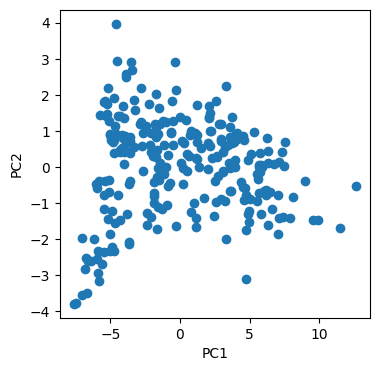

In [35]:
# The predicted probabilities shows heterogeneity of the cells. We use PCA to visualize the cells in 2D space, but UMAP or t-SNE can be used for better visualization.
import sklearn.decomposition
model_pca = sklearn.decomposition.PCA(n_components = 2)
df_predict_sc_pca = model_pca.fit_transform(df_predict_sc_wide.T)
df_predict_sc_pca = pd.DataFrame(df_predict_sc_pca, index = df_predict_sc_wide.columns, columns = ["PC1", "PC2"])

fig, ax = plt.subplots(1,1,figsize= (4,4))
ax.scatter(df_predict_sc_pca["PC1"], df_predict_sc_pca["PC2"])
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
fig.show()

## Fine-tuning

We use the same fine-tuning strategy as for other tasks, but with a different dataset. The fine-tuning dataset is in HDF5 (`.h5`) format and is similar to the one used for single-cell cistrome imputation.  

It should include two additional tables: `regulators` and `label`.  

- The `regulators` table must have the same length as the `cell` table to ensure proper pairing.  
- The `label` table should have rows corresponding to `regions` and columns corresponding to `regulators` and `cell`.  

For practical fine-tuning use cases, please refer to the [code](https://chrombert.readthedocs.io/en/latest/finetune.html#prompt-enhanced).
